In [ ]:
import torch
from PIL import Image
from torchvision import transforms
from dinov3.models.vision_transformer import vit_large
import netCDF4 as nc
import numpy as np
import os
import re
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity

# Path to your model weights
weights_path = "dinov3/weights/dinov3_vitl16_pretrain_sat493m-eadcf0ff.pth"

# Create model
model = vit_large(patch_size=16, num_classes=0)
state_dict = torch.load(weights_path, map_location="cpu")
model.load_state_dict(state_dict, strict=False)
model.eval()

print("✅ DINOv3 ViT-L/16 (SAT-493M) loaded successfully!")

# Preprocessing (same normalization used in training)
transform = transforms.Compose([
    transforms.Resize(518),
    transforms.CenterCrop(518),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])



########

lat_min, lat_max = -75,75
lon_min, lon_max = -75,75

data_dir = "/Users/carmenoliver/Desktop/SIF_anomalies/SIF_DATA_TROPOMI/"

files = sorted([f for f in os.listdir(data_dir) if f.endswith(".nc")])
print("Files found:", files)


sif_amazon = []
time_list = []

data_dir = data_dir = "/Users/carmenoliver/Desktop/SIF_anomalies/SIF_DATA_TROPOMI/"

# Get all available files
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".nc")])
print("Files found:", files)
for file in files:
    match = re.search(r"month-(\d{6})", file)
    if match:
        date_str = match.group(1)  
        year = int(date_str[:4])  
        month = int(date_str[4:6])  

        file_path = os.path.join(data_dir, file)
        
        try:
            ds = xr.open_dataset(file_path)
        except Exception as e:
            print(f"Error opening {file_path}: {e}")
            continue
        ds_amazon = ds.sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))
        
        sif_amazon.append(ds_amazon["solar_induced_fluorescence"].values)  
        time_list.append(f"{year}-{month:02d}")
        # Ensure data was loaded
if not sif_amazon or not time_list:
    raise ValueError("No valid data found. Check the input files and filtering logic.")
sif_amazon = np.stack(sif_amazon, axis=0).squeeze()  # Shape: [N_months, lat, lon]

years = sorted(set(int(t.split("-")[0]) for t in time_list))
num_years = len(years)

sif_monthly = np.full((num_years, 12, *sif_amazon.shape[1:]), np.nan)
for i, month_data in enumerate(sif_amazon):
    year_idx = i // 12  
    month_idx = i % 12  
    sif_monthly[year_idx, month_idx] = month_data 


print("Fixed sif_monthly shape:", sif_monthly.shape)


# # Compute DINOv3 embeddings for all months and years
# all_embeddings = []
# for year_idx in range(sif_monthly.shape[0]):
#     for month_idx in range(sif_monthly.shape[1]):
#         sif_img = sif_monthly[year_idx, month_idx]
#         if np.isnan(sif_img).all():
#             all_embeddings.append(np.full((1, model.embed_dim), np.nan))
#             continue
#         sif_min, sif_max = np.nanmin(sif_img), np.nanmax(sif_img)
#         sif_norm = (sif_img - sif_min) / (sif_max - sif_min + 1e-8)
#         sif_rgb = np.stack([sif_norm]*3, axis=-1)
#         sif_rgb_img = Image.fromarray((sif_rgb * 255).astype(np.uint8))
#         x_sif = transform(sif_rgb_img).unsqueeze(0)
#         with torch.no_grad():
#             sif_feats = model(x_sif)
#         all_embeddings.append(sif_feats.cpu().numpy())

# all_embeddings = np.concatenate(all_embeddings, axis=0)  # shape: [N_months_total, embedding_dim]
# print("✅ All SIF embeddings shape:", all_embeddings.shape)


# pca = PCA(n_components=2, random_state=0)
# X_pca = pca.fit_transform(all_embeddings)


# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=2, random_state=0).fit(X_pca)
# labels = kmeans.labels_

# plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10')
# plt.title("Unsupervised clusters of SIF embeddings")
# plt.show()


# plt.plot(range(len(labels)), labels, marker='o')
# plt.title("Cluster evolution over time")
# plt.xlabel("Time step")
# plt.ylabel("Cluster ID")
# plt.show()



In [ ]:
pca = PCA(n_components=3, random_state=0)
X_pca = pca.fit_transform(all_embeddings)


from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0).fit(X_pca)
labels = kmeans.labels_

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10')
plt.title("Unsupervised clusters of SIF embeddings")
plt.show()


plt.plot(range(len(labels)), labels, marker='o')
plt.title("Cluster evolution over time")
plt.xlabel("Time step")
plt.ylabel("Cluster ID")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import math

# Assume 'labels' is your array of cluster labels
# and 'sif_monthly' and 'time_list' are your data arrays.

# Number of images you want to plot
n_subset = 70

# Select only the first 20 images
indices = range(n_subset)

plt.figure(figsize=(24, 12))
cols = 5  # number of columns (adjust for clarity)
rows = math.ceil(n_subset / cols)

for i, idx in enumerate(indices):
    year_idx = idx // 12
    month_idx = idx % 12
    sif_img = sif_monthly[year_idx, month_idx]
    cluster_id = labels[idx]
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sif_img, cmap='viridis')
    plt.title(f"{time_list[idx]}\nCluster {cluster_id}")
    plt.axis('off')

plt.suptitle("Sample of 20 SIF images with cluster assignment")
plt.tight_layout()
plt.show()



Ignored kwargs: {'num_classes': 0}


✅ DINOv3 ViT-L/16 (SAT-493M) loaded.
📦 Found 72 SIF files.
(1, 7509, 7509)


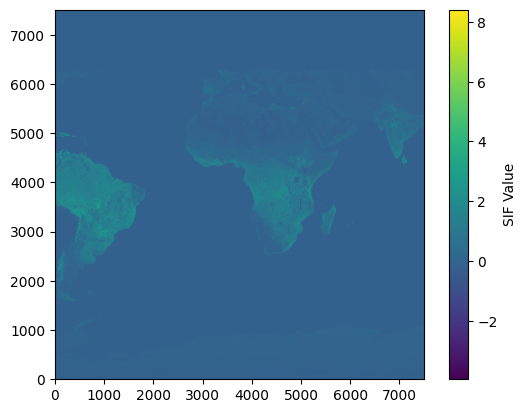

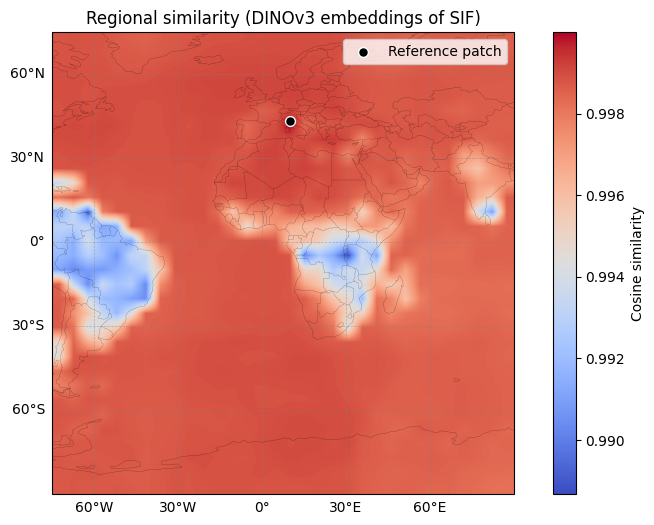

In [ ]:
import os, math, torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from sklearn.metrics.pairwise import cosine_similarity
from dinov3.models.vision_transformer import vit_large
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import torch.nn.functional as F
import matplotlib.ticker as mticker



# --- CONFIG ---
data_dir = "/Users/carmenoliver/Desktop/SIF_anomalies/SIF_DATA_TROPOMI/"
weights_path = "dinov3/weights/dinov3_vitl16_pretrain_sat493m-eadcf0ff.pth"
lat_min, lat_max = -90, 75
lon_min, lon_max = -75, 90
patch_size = 16  # DINOv3-L/16

# --- LOAD MODEL ---
model = vit_large(patch_size=patch_size, num_classes=0)
state_dict = torch.load(weights_path, map_location="cpu")
model.load_state_dict(state_dict, strict=False)
model.eval()
print("✅ DINOv3 ViT-L/16 (SAT-493M) loaded.")

# --- PREPROCESSING PIPELINE ---
transform = transforms.Compose([
    transforms.Resize(518),
    transforms.CenterCrop(518),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def get_patch_embeddings(x):
    """Return patch embeddings (no CLS token)."""
    with torch.no_grad():
        feats = model.forward_features(x)
    return feats["x_norm_patchtokens"].squeeze(0).cpu()  # (N_patches, 1024)

# --- LOAD SIF DATA ---
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".nc")])
if not files:
    raise FileNotFoundError("No .nc files found in data_dir.")

print(f"📦 Found {len(files)} SIF files.")
first_file = os.path.join(data_dir, files[23])
ds = xr.open_dataset(first_file)
sif = ds["solar_induced_fluorescence"].sel(latitude=slice(lat_min, lat_max),
                                           longitude=slice(lon_min, lon_max)).values
sif = np.nan_to_num(sif, nan=-1)

print(sif.shape)


plt.imshow(sif[0], cmap='viridis', origin='lower')
plt.colorbar(label="SIF Value")

# --- PREPARE IMAGE ---

# Normalize and convert to fake RGB
sif_img = sif[0]
sif_min, sif_max = np.percentile(sif_img, [1, 99])  # robust normalization
sif_norm = np.clip((sif_img - sif_min) / (sif_max - sif_min + 1e-8), 0, 1)
sif_rgb = np.stack([sif_norm]*3, axis=-1)
sif_rgb_img = Image.fromarray((sif_rgb * 255).astype(np.uint8))
x_sif = transform(sif_rgb_img).unsqueeze(0)  # shape [1, 3, 518, 518]

# --- EMBEDDINGS ---
patch_embs = get_patch_embeddings(x_sif)
H, W = x_sif.shape[2:]  # (518, 518)
n_h, n_w = H // patch_size, W // patch_size
patch_grid = patch_embs.reshape(n_h, n_w, -1)

# --- COSINE SIMILARITY MAP ---
ref_y, ref_x = 25, n_w // 2  # center patch
sim_map = cosine_similarity(
    patch_grid[ref_y, ref_x].reshape(1, -1),
    patch_grid.reshape(-1, patch_grid.shape[-1])
).reshape(n_h, n_w)

sim_map= F.interpolate(
    torch.tensor(sim_map)[None, None, :, :],
    size=sif[0].shape,
    mode='bilinear',
    align_corners=False
).squeeze().numpy()

# --- LAT/LON GRID ---
lats = np.linspace(lat_min, lat_max, n_h)
lons = np.linspace(lon_min, lon_max, n_w)

# --- PLOT ---
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Plot similarity heatmap
im = ax.imshow(
    sim_map,
    origin="lower",
    extent=[lon_min, lon_max, lat_min, lat_max],
    cmap="coolwarm",
    transform=ccrs.PlateCarree(),
    interpolation="nearest"
)

# Mark the reference patch on the map
ax.scatter(
    lons[ref_x], lats[ref_y],
    color="black", s=50, edgecolor="white",
    transform=ccrs.PlateCarree(),
    label="Reference patch"
)
ax.legend(loc="upper right")
# Add coastlines and borders
ax.coastlines(resolution='110m', linewidth=0.1)
ax.add_feature(cfeature.BORDERS, linewidth=0.1)
ax.add_feature(cfeature.LAND, facecolor='none', edgecolor='green', alpha=0.3)

# Add latitude / longitude gridlines and labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', label="Cosine similarity")

plt.title("Regional similarity (DINOv3 embeddings of SIF)")
plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go
from plotly.graph_objs import FigureWidget
from IPython.display import display

# Assume patch_grid shape (n_h, n_w, 1024), sif[0] shape (H, W), lats shape (n_h,), lons shape (n_w,)
# Define n_h, n_w, lat_min, lat_max, lon_min, lon_max accordingly

def compute_similarity_map(idx_y, idx_x):
    # Vector for selected patch
    patch_vec = patch_grid[idx_y, idx_x].reshape(1, -1)

    # Cosine similarity with all patches (flattened)
    sim_map = cosine_similarity(patch_vec, patch_grid.reshape(-1, patch_grid.shape[-1]))
    sim_map = sim_map.reshape(n_h, n_w)

    # Upsample to SIF resolution using PyTorch interpolate
    sim_map_tensor = torch.tensor(sim_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    sim_map_up = F.interpolate(sim_map_tensor, size=sif[0].shape, mode='bilinear', align_corners=False)
    return sim_map_up.squeeze().numpy()

# Initial display similarity zeros
sim_map_display = np.zeros_like(sif[0])

# Create figure widget and heatmap trace
fig = FigureWidget()
heatmap = go.Heatmap(
    z=sim_map_display,
    x=np.linspace(lons.min(), lons.max(), sif[0].shape[1]),
    y=np.linspace(lats.min(), lats.max(), sif[0].shape[0]),
    colorscale='RdBu',
    colorbar=dict(title="Cosine similarity"),
    zmin=0,
    zmax=1
)
fig.add_trace(heatmap)
fig.update_layout(
    title="Click on a coordinate to compute similarity",
    xaxis_title="Longitude",
    yaxis_title="Latitude",
    yaxis=dict(scaleanchor="x", scaleratio=1)
)
display(fig)

def interactive_plot(trace, points, selector):
    if points.point_inds:
        lon_clicked = points.xs[0]
        lat_clicked = points.ys[0]

        # Find closest indices in patch grid coordinates
        idx_x = np.abs(lons - lon_clicked).argmin()
        idx_y = np.abs(lats - lat_clicked).argmin()

        print(f"Clicked lat={lat_clicked:.2f}, lon={lon_clicked:.2f} -> patch y={idx_y}, x={idx_x}")

        # Compute similarity map with optimized vector operation
        sim_map_new = compute_similarity_map(idx_y, idx_x)

        # Update heatmap efficiently within batch_update
        with fig.batch_update():
            trace.z = sim_map_new
            trace.zmin = sim_map_new.min()
            trace.zmax = sim_map_new.max()

# Connect callback only once to heatmap trace of FigureWidget
fig.data[0].on_click(interactive_plot)
